The following tutorial is available on the [Wallaroo Github Repository](https://github.com/WallarooLabs/Wallaroo_Tutorials/blob/wallaroo2025.1_tutorials/wallaroo-run-anywhere/inference/publish/edge-computer-vision-yolov8-publish).

## Computer Vision Yolov8n Pipeline Edge Publish

The [Yolov8](https://github.com/ultralytics/ultralytics) computer vision model is used for fast recognition of objects in images.  This tutorial demonstrates how to deploy a Yolov8n pre-trained model into a Wallaroo Ops server and perform inferences on it.

Wallaroo Ops Center provides the ability to publish Wallaroo pipelines to an Open Continer Initative (OCI) compliant registry, then deploy those pipelines on edge devices as Docker container or Kubernetes pods.  See [Wallaroo SDK Essentials Guide: Pipeline Edge Publication](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-pipelines/wallaroo-sdk-essentials-pipeline-publication/) for full details.

For this tutorial, the helper module `CVDemoUtils` and `WallarooUtils` are used to transform a sample image into a pandas DataFrame.  This DataFrame is then submitted to the Yolov8n model deployed in Wallaroo.

This demonstration follows these steps:

* In Wallaroo Ops:
  * Upload the Yolo8 model to Wallaroo Ops
  * Add the Yolo8 model as a Wallaroo pipeline step
  * Deploy the Wallaroo pipeline and allocate cluster resources to the pipeline
  * Perform sample inferences
  * Undeploy and return the resources to the cluster.
  * Publish the pipeline to the OCI registry configured in the Wallaroo Ops server.

Upon completion, the follow up tutorial [Computer Vision Yolov8n Pipeline Deploy in Wallaroo](https://github.com/WallarooLabs/Wallaroo_Tutorials/blob/wallaroo2025.1_tutorials/wallaroo-run-anywhere/inference/deploy/edge-computer-vision-yolov8-deploy) shows how to deploy this publish and perform sample inferences on an edge/multi-cloud device.

## Tutorial Notes

To run this tutorial in the **Wallaroo JupyterHub Service**, import the `tensorflow-cpu` library by executing the following command in the terminal shell:

```bash
pip install tensorflow-cpu==2.13.1 --user
```

Then proceed with the tutorial.  This **only** applies to running this tutorial in Wallaroo's JupyterHub service, and does **not** affect model upload and packaging in Wallaroo.

## References

* [Wallaroo Workspaces](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-workspace/):  Workspaces are environments were users upload models, create pipelines and other artifacts.  The workspace should be considered the fundamental area where work is done.  Workspaces are shared with other users to give them access to the same models, pipelines, etc.
* [Wallaroo Model Upload and Registration](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-model-uploads/): ML Models are uploaded to Wallaroo through the SDK or the MLOps API to a **workspace**.  ML models include default runtimes (ONNX, Python Step, and TensorFlow) that are run directly through the Wallaroo engine, and containerized runtimes (Hugging Face, PyTorch, etc) that are run through in a container through the Wallaroo engine.
* [Wallaroo Pipelines](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-pipelines/): Pipelines are used to deploy models for inferencing.  Each model is a **pipeline step** in a pipelines, where the inputs of the previous step are fed into the next.  Pipeline steps can be ML models, Python scripts, or Custom Model (these contain necessary models and artifacts for running a model).
* [Wallaroo SDK Essentials Guide: Pipeline Edge Publication](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-pipelines/wallaroo-sdk-essentials-pipeline-publication/): Details on publishing a Wallaroo pipeline to an OCI Registry and deploying it as a Wallaroo Server instance.

## Data Scientist Steps

The following details the steps a Data Scientist performs in uploading and verifying the model in a Wallaroo Ops server.

### Load Libraries

The first step is loading the required libraries including the [Wallaroo Python module](https://pypi.org/project/wallaroo/).

In [6]:
# Import Wallaroo Python SDK
import wallaroo
from wallaroo.object import EntityNotFoundError
from wallaroo.framework import Framework
from CVDemoUtils import CVDemo
from WallarooUtils import Util
cvDemo = CVDemo()
util = Util()

# used to display DataFrame information without truncating
from IPython.display import display
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)


### Connect to the Wallaroo Instance through the User Interface

The next step is to connect to Wallaroo through the Wallaroo client.  The Python library is included in the Wallaroo install and available through the Jupyter Hub interface provided with your Wallaroo environment.

This is accomplished using the `wallaroo.Client()` command, which provides a URL to grant the SDK permission to your specific Wallaroo environment.  When displayed, enter the URL into a browser and confirm permissions.  Store the connection into a variable that can be referenced later.

If logging into the Wallaroo instance through the internal JupyterHub service, use `wl = wallaroo.Client()`.  For more information on Wallaroo Client settings, see the [Client Connection guide](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-client/).

In [7]:
wl = wallaroo.Client()

### Create a New Workspace

We'll use the SDK below to create our workspace , assign as our **current workspace**, then display all of the workspaces we have at the moment.  We'll also set up variables for our models and pipelines down the road, so we have one spot to change names to whatever fits your organization's standards best.

To allow this tutorial to be run by multiple users in the same Wallaroo instance, a random 4 character prefix will be added to the workspace, pipeline, and model.  Feel free to set `suffix=''` if this is not required.

In [8]:
model_name = 'yolov8n'
model_filename = './models/yolov8n.onnx'
pipeline_name = 'yolo8demonstration'
workspace_name = f'yolo8-edge-demonstration'


In [9]:
workspace = wl.get_workspace(name=workspace_name, create_if_not_exist=True)
wl.set_current_workspace(workspace)

{'name': 'yolo8-edge-demonstration', 'id': 14, 'archived': False, 'created_by': 'ea2c3caf-86e1-4501-ad82-c8a09d518bf1', 'created_at': '2025-04-29T20:04:41.381796+00:00', 'models': [], 'pipelines': []}

### Upload the Model

When a model is uploaded to a Wallaroo cluster, it is optimized and packaged to make it ready to run as part of a pipeline. In many times, the Wallaroo Server can natively run a model without any Python overhead. In other cases, such as a Python script, a custom Python environment will be automatically generated. This is comparable to the process of "containerizing" a model by adding a small HTTP server and other wrapping around it.

Our pretrained model is in ONNX format, which is specified in the `framework` parameter.  For this model, the tensor fields are set to `images` to match the input parameters, and the batch configuration is set to `single` - only one record will be submitted at a time.

In [10]:
# Upload Retrained Yolo8 Model 
yolov8_model = (wl.upload_model(model_name, 
                               model_filename, 
                               framework=Framework.ONNX)
                               .configure(tensor_fields=['images'],
                                          batch_config="single"
                                          )
                )

### Pipeline Deployment Configuration

For our pipeline we set the deployment configuration to only use 1 cpu and 1 GiB of RAM.

In [11]:
deployment_config = wallaroo.DeploymentConfigBuilder() \
                    .replica_count(1) \
                    .cpus(1) \
                    .memory("1Gi") \
                    .build()

### Build and Deploy the Pipeline

Now we build our pipeline and set our Yolo8 model as a pipeline step, then deploy the pipeline using the deployment configuration above.

In [12]:
pipeline = wl.build_pipeline(pipeline_name) \
            .add_model_step(yolov8_model)        

In [16]:
pipeline.deploy(deployment_config=deployment_config,
                wait_for_status=False)

Deployment initiated for yolo8demonstration. Please check pipeline status.


name,yolo8demonstration
created,2025-04-29 20:04:44.690542+00:00
last_updated,2025-04-29 20:09:17.002958+00:00
deployed,True
workspace_id,14
workspace_name,yolo8-edge-demonstration
arch,x86
accel,none
tags,
versions,"51a432c0-b785-42ce-abeb-19424fccd6f4, b3a05b11-9ee2-489c-ac53-8429311aaff2, fd2913bd-6242-413a-a6a8-6be40cb605ab"
steps,yolov8n


In [17]:
# wait for the pipeline status = Running
import time
time.sleep(15)

while pipeline.status()['status'] != 'Running':
    time.sleep(15)
    print("Waiting for deployment.")
    print(pipeline.status()['status'])
print(pipeline.status()['status'])

Running


### Convert Image to DataFrame

The sample image `dogbike.png` was converted to a DataFrame using the `cvDemo` helper modules.  The converted DataFrame is stored as `./data/dogbike.df.json` to save time.

The code sample below demonstrates how to use this module to convert the sample image to a DataFrame.

```python
# convert the image to a tensor

width, height = 640, 640
tensor1, resizedImage1 = cvDemo.loadImageAndResize('dogbike.png', width, height)
tensor1.flatten()

# add the tensor to a DataFrame and save the DataFrame in pandas record format
df = util.convert_data(tensor1,'images')
df.to_json("data.json", orient = 'records')
```

### Inference Request

We submit the DataFrame to the pipeline using `wallaroo.pipeline.infer`, and store the results in the variable `inf1`.  A copy of the dataframe is stored in the file `./data/dogbike.df.json`.

In [18]:
width, height = 640, 480
tensor1, resizedImage1 = cvDemo.loadImageAndResize('./data/dogbike.png', width, height)

inf1 = pipeline.infer_from_file('./data/dogbike.df.json')

### Display Bounding Boxes

Using our helper method `cvDemo` we'll identify the objects detected in the photo and their bounding boxes.  Only objects with a confidence threshold of 50% or more are shown.

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/Users/johnhansarick/Library/Application Support/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
  Score: 86.47% | Class: Dog | Bounding Box: [108, 250, 149, 356]
  Score: 81.13% | Class: Bicycle | Bounding Box: [97, 149, 375, 323]
  Score: 63.17% | Class: Car | Bounding Box: [390, 85, 186, 108]


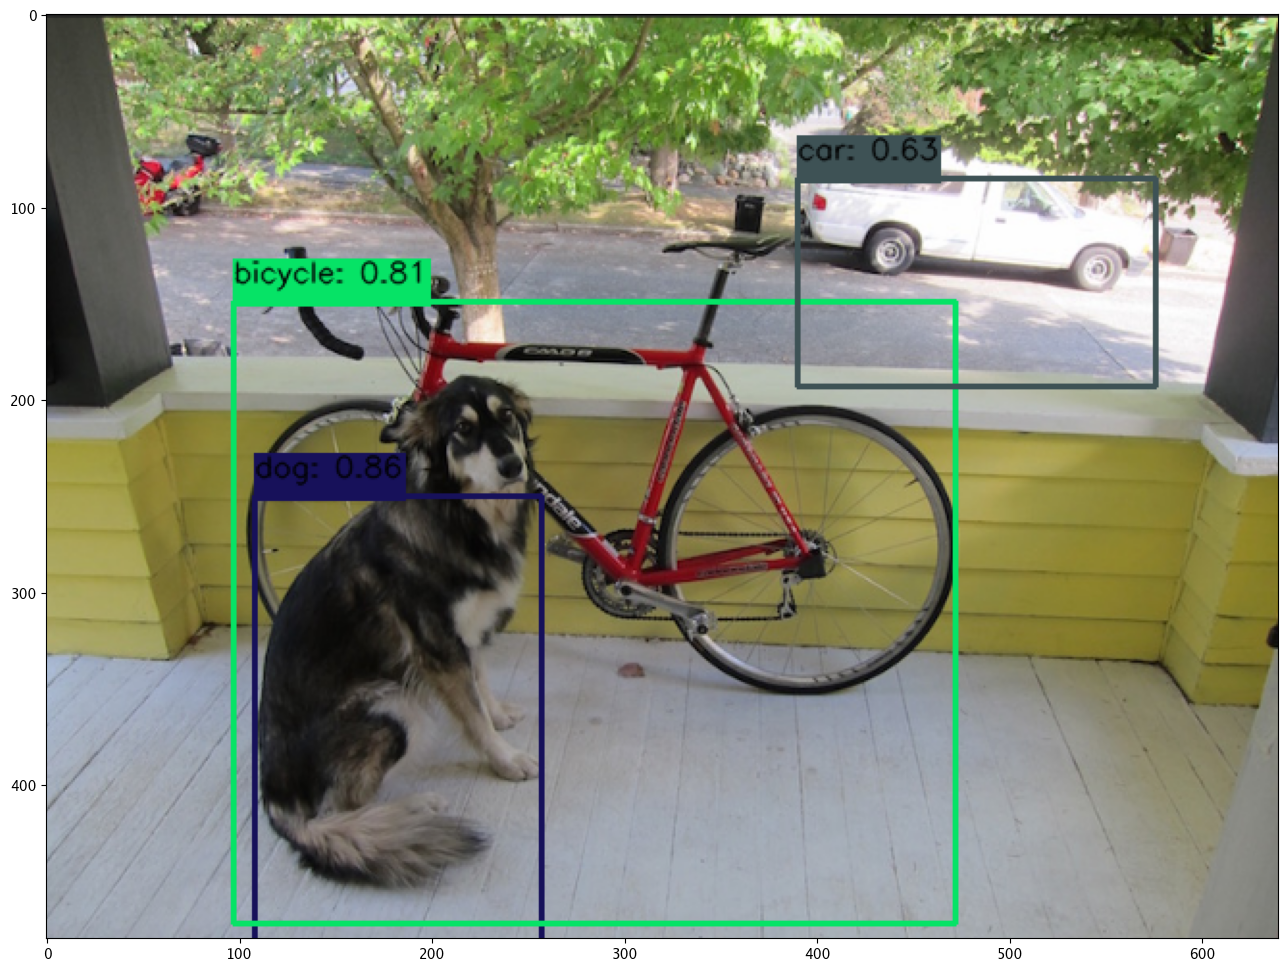

array([[[ 34,  34,  34],
        [ 35,  35,  35],
        [ 33,  33,  33],
        ...,
        [ 33,  33,  33],
        [ 33,  33,  33],
        [ 35,  35,  35]],

       [[ 41,  41,  39],
        [ 42,  42,  40],
        [ 42,  42,  40],
        ...,
        [ 81,  91,  64],
        [ 80,  92,  63],
        [ 83,  90,  59]],

       [[ 59,  61,  53],
        [ 61,  62,  54],
        [ 61,  62,  54],
        ...,
        [193, 228, 136],
        [195, 236, 136],
        [203, 224, 122]],

       ...,

       [[159, 167, 178],
        [160, 166, 178],
        [160, 165, 177],
        ...,
        [126, 127, 121],
        [126, 125, 120],
        [127, 121, 117]],

       [[160, 168, 179],
        [157, 163, 175],
        [154, 159, 171],
        ...,
        [126, 127, 121],
        [128, 126, 121],
        [127, 119, 116]],

       [[156, 164, 175],
        [155, 162, 174],
        [152, 158, 170],
        ...,
        [127, 127, 121],
        [130, 126, 122],
        [128, 119, 116]]

In [20]:
confidence_thres = 0.50
iou_thres = 0.25

cvDemo.drawYolo8Boxes(inf1, resizedImage1, width, height, confidence_thres, iou_thres, draw=True)

### Inference Through Pipeline API

Another method of performing an inference using the pipeline's deployment url.

Performing an inference through an API requires the following:

* The authentication token to authorize the connection to the pipeline.
* The pipeline's inference URL.
* Inference data to sent to the pipeline - in JSON, DataFrame records format, or Apache Arrow.

Full details are available through the [Wallaroo API Connection Guide](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-api-guide/wallaroo-mlops-connection-guide/) on how retrieve an authorization token and perform inferences through the pipeline's API.

For this demonstration we'll submit the pandas record, request a pandas record as the return, and set the authorization header.  The results will be stored in the file `curl_response.df`.

In [21]:
deploy_url = pipeline._deployment._url()

headers = wl.auth.auth_header()

headers['Content-Type']='application/json; format=pandas-records'
headers['Accept']='application/json; format=pandas-records'

In [22]:
!curl -X POST {deploy_url} \
    -H "Authorization:{headers['Authorization']}" \
    -H "Content-Type:application/json; format=pandas-records" \
    -H "Accept:application/json; format=pandas-records" \
    --data @./data/dogbike.df.json > curl_response.df

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 38.0M  100 22.9M  100 15.0M  3013k  1983k  0:00:07  0:00:07 --:--:-- 4405k


In [23]:
pipeline.undeploy()

name,yolo8demonstration
created,2025-04-29 20:04:44.690542+00:00
last_updated,2025-04-29 20:09:17.002958+00:00
deployed,False
workspace_id,14
workspace_name,yolo8-edge-demonstration
arch,x86
accel,none
tags,
versions,"51a432c0-b785-42ce-abeb-19424fccd6f4, b3a05b11-9ee2-489c-ac53-8429311aaff2, fd2913bd-6242-413a-a6a8-6be40cb605ab"
steps,yolov8n


### Publish the Pipeline for Edge Deployment

It worked! For a demo, we'll take working once as "tested". So now that we've tested our pipeline, we are ready to publish it for edge deployment.

Publishing it means assembling all of the configuration files and model assets and pushing them to an Open Container Initiative (OCI) repository set in the Wallaroo instance as the Edge Registry service.  DevOps engineers then retrieve that image and deploy it through Docker, Kubernetes, or similar deployments.

See [Edge Deployment Registry Guide](https://docs.wallaroo.ai/wallaroo-platform-operations/wallaroo-platform-operations-configure/wallaroo-edge-deployment/) for details on adding an OCI Registry Service to Wallaroo as the Edge Deployment Registry.

This is done through the SDK command `wallaroo.pipeline.publish(deployment_config)`.

### Publish Example

We will now publish the pipeline to our Edge Deployment Registry with the `pipeline.publish(deployment_config)` command.  `deployment_config` is an optional field that specifies the pipeline deployment.  This can be overridden by the DevOps engineer during deployment.

In [24]:
pub = pipeline.publish(deployment_config)
pub

Waiting for pipeline publish... It may take up to 600 sec.
Pipeline is publishing..... Published.


ID,2
Pipeline Name,yolo8demonstration
Pipeline Version,960dc42c-2aaf-4b18-81b1-4d2a8027eb75
Status,Published
Engine URL,ghcr.io/wallaroolabs/doc-samples/engines/proxy/wallaroo/ghcr.io/wallaroolabs/fitzroy-mini:v2024.4.0-6077
Pipeline URL,ghcr.io/wallaroolabs/doc-samples/pipelines/yolo8demonstration:960dc42c-2aaf-4b18-81b1-4d2a8027eb75
Helm Chart URL,oci://ghcr.io/wallaroolabs/doc-samples/charts/yolo8demonstration
Helm Chart Reference,ghcr.io/wallaroolabs/doc-samples/charts@sha256:0b4d4dd37daed6628f03ea4d618bf5ae1538f8531ccd86522b141385c2a0e869
Helm Chart Version,0.0.1-960dc42c-2aaf-4b18-81b1-4d2a8027eb75
Engine Config,"{'engine': {'resources': {'limits': {'cpu': 1.0, 'memory': '1Gi'}, 'requests': {'cpu': 1.0, 'memory': '1Gi'}, 'accel': 'none', 'arch': 'x86', 'gpu': False}}, 'engineAux': {'autoscale': {'type': 'none'}, 'images': {}}}"
User Images,[]


### List Published Pipeline

The method `wallaroo.client.list_pipelines()` shows a list of all pipelines in the Wallaroo instance, and includes the `published` field that indicates whether the pipeline was published to the registry (`True`), or has not yet been published (`False`).

In [25]:
wl.list_pipelines()

name,created,last_updated,deployed,workspace_id,workspace_name,arch,accel,tags,versions,steps,published
rental-forecast-workshop-sample,2025-09-Apr 16:31:19,2025-09-Apr 16:54:54,False,8,forecast-sample-last-test,x86,none,,"a22cdf51-0124-4f94-92fe-137a2e3106ee, 05e0e413-9822-410b-9b24-f89f95902df0, 4f78a719-eed5-45c3-8f02-478fe1a8fda1, 9b610019-f78e-431d-a9e3-63dcdfbd9c1a, 4591de52-8b54-4b54-a5e8-51427ccf19ed",reservations-xgboost,False
assay-demonstration-tutorial,2025-09-Apr 18:53:48,2025-09-Apr 18:54:02,False,10,assay-demonstration-tutorial-2,x86,none,,"26d00f1e-1cd4-42b0-a994-c8a0a16888e7, 1b07cff9-5e9f-4e6d-b094-64df04e5f4f0, 24a506d9-e8af-49a4-8a80-6b637da6853a, 5363559e-f5be-46fc-b275-915ee00d4e78",house-price-estimator,False
assay-demonstration-tutorial,2025-09-Apr 16:06:07,2025-10-Apr 20:48:36,False,7,assay-demonstration-tutorial,x86,none,,"53bd5246-cce7-492e-add4-337e639c9176, d356bf98-3d55-4b96-b1fe-da2044ce4dd8, 2b0eb1a9-33b6-4403-aa68-f34ba072163d, ddae3a00-13c8-469b-bda7-6a25ae089166, 64fe4837-7311-4651-b8f9-67cbfdc8a70f, 9ffe4dc5-4078-4864-b6f1-6dd3fe4f1429",house-price-estimator,False
pt-unet,2025-29-Apr 18:37:28,2025-29-Apr 18:51:28,False,13,unet-detection-run-anywhere-demonstration,x86,none,,"18a2e65e-d600-471f-80fe-6b60030f9dda, a32cfc3f-9811-4347-9adb-39b99b84ef14, d47c0dbb-366a-4cee-894f-73d3cb0cb9a0",pt-unet,True
vgg16-clustering-pipeline,2025-29-Apr 18:04:02,2025-29-Apr 18:58:46,False,12,vgg16-clustering-workspace,x86,none,,"d23d2980-4bf9-4aaf-9512-c9a1df83373d, 18ee0c91-fea3-48e1-8e66-2d3baf158d36, 570cc651-6635-4d05-b334-45702869d333, f033992b-02f1-4ee9-9f83-4bb3d08502a9, 9bff7dd7-48ca-4f4e-996f-4f5f1911d01d, f80de3ca-c847-4dca-bcfe-8dfa22fa4093, 83fcb6c4-8c46-40b6-9162-5a6d0f8b337c, a4260dda-8432-492a-9932-f2a8ec60dd2b, a04ff64c-11f1-4c23-a3d1-80ad20f874d4, 52a75b1b-fcfe-44be-b2f2-bdc2665966ef, b77de86a-2b48-4669-9570-b78f198ba19a",vgg16-clustering,False
yolo8demonstration,2025-29-Apr 20:04:44,2025-29-Apr 20:11:27,False,14,yolo8-edge-demonstration,x86,none,,"960dc42c-2aaf-4b18-81b1-4d2a8027eb75, 51a432c0-b785-42ce-abeb-19424fccd6f4, b3a05b11-9ee2-489c-ac53-8429311aaff2, fd2913bd-6242-413a-a6a8-6be40cb605ab",yolov8n,True


### List Publishes from a Pipeline

All publishes created from a pipeline are displayed with the `wallaroo.pipeline.publishes` method.  The `pipeline_version_id` is used to know what version of the pipeline was used in that specific publish.  This allows for pipelines to be updated over time, and newer versions to be sent and tracked to the Edge Deployment Registry service.

#### List Publishes Parameters

N/A

#### List Publishes Returns

A List of the following fields:

| Field | Type | Description |
|---|---|---|
| id | integer | Numerical Wallaroo id of the published pipeline. |
| pipeline_version_id | integer | Numerical Wallaroo id of the pipeline version published. |
| engine_url | string | The URL of the published pipeline engine in the edge registry. |
| pipeline_url | string | The URL of the published pipeline in the edge registry. |
| created_by | string | The email address of the user that published the pipeline.
| Created At | DateTime | When the published pipeline was created. |
| Updated At | DateTime | When the published pipeline was updated. |

In [26]:
pipeline.publishes()

id,pipeline_version_name,engine_url,pipeline_url,created_by,created_at,updated_at
2,960dc42c-2aaf-4b18-81b1-4d2a8027eb75,ghcr.io/wallaroolabs/doc-samples/engines/proxy/wallaroo/ghcr.io/wallaroolabs/fitzroy-mini:v2024.4.0-6077,ghcr.io/wallaroolabs/doc-samples/pipelines/yolo8demonstration:960dc42c-2aaf-4b18-81b1-4d2a8027eb75,john.hansarick@wallaroo.ai,2025-29-Apr 20:11:29,2025-29-Apr 20:11:29


Upon completion, the follow up tutorial [Computer Vision Yolov8n Pipeline Deploy in Wallaroo](https://github.com/WallarooLabs/Wallaroo_Tutorials/blob/wallaroo2025.1_tutorials/wallaroo-run-anywhere/inference/deploy/edge-computer-vision-yolov8-deploy) shows how to deploy this publish and perform sample inferences on an edge/multi-cloud device.